# Import libraries

In [1]:
# !pip install tensorflow==2.8
# !pip install tensorflowjs
# !pip install numpy==1.21
# !pip install protobuf==3.20.*
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn

In [2]:
import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.utils import set_random_seed
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

In [3]:
import tensorflowjs as tfjs

# Setting a seed
Setting a seed so we can guarantee the same results no matter how many times we run the script

In [4]:
seed = 1605
np.random.seed(seed)
set_random_seed(seed)

# Setting the image directory

In [5]:
train_path = pathlib.Path("./data/train")
val_path = pathlib.Path('./data/val')
test_path = pathlib.Path('./data/test')

train_data = list(train_path.glob('*/*.jpeg'))

In [6]:
subpath = list(train_path.glob('*'))
species = []
boxplot_data = []

for i in range (0, len(subpath)):
    species.append(subpath[i].name)
    boxplot_data.append([subpath[i].name, len(os.listdir(subpath[i]))])

species.sort()
species

['1355932',
 '1355936',
 '1355937',
 '1355990',
 '1356022',
 '1356075',
 '1356257',
 '1356382',
 '1356781',
 '1357330',
 '1357635',
 '1358094',
 '1358095',
 '1358133',
 '1358689',
 '1358752',
 '1358766',
 '1359498',
 '1359517',
 '1359616',
 '1359620',
 '1360978',
 '1361656',
 '1361823',
 '1361824',
 '1362490',
 '1363128',
 '1363130',
 '1363227',
 '1363336',
 '1363740',
 '1363764',
 '1363991',
 '1364099',
 '1364159',
 '1364164',
 '1364173',
 '1367432',
 '1369887',
 '1374048',
 '1384485',
 '1385937',
 '1389510',
 '1392475',
 '1393241',
 '1393423',
 '1393425',
 '1393614',
 '1394382',
 '1394420',
 '1394454',
 '1394460',
 '1394591',
 '1394994',
 '1396824',
 '1397268',
 '1397364',
 '1398178',
 '1398592',
 '1400100',
 '1408774',
 '1408961',
 '1409238',
 '1418146',
 '1435714']

In [7]:
no_of_files = pd.DataFrame(columns=['Species', 'No of files'], data=boxplot_data)
count_more_than_1000 = 0
list_of_species_to_keep = []

for index, row in no_of_files.iterrows():
    if row['No of files'] >= 1000:
        count_more_than_1000 += 1
        list_of_species_to_keep.append(row['Species'])
        
list_of_species_to_keep        
count_more_than_1000

65

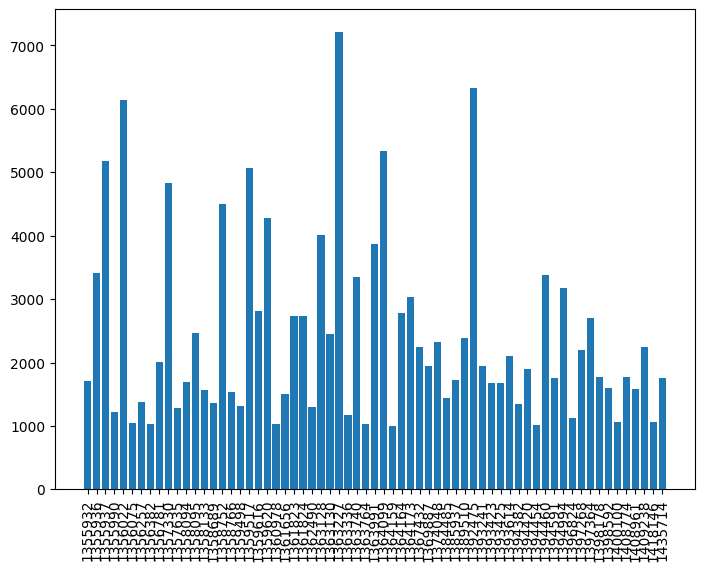

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plot_species = no_of_files['Species']
plot_numbers = no_of_files['No of files']
ax.bar(plot_species,plot_numbers)
plt.xticks(rotation = 90)
plt.show()

# Setting image height and width

In [9]:
image_size = (150, 150) # (height, width)

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=1337,
    image_size=image_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=1337,
    image_size=image_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=1337,
    image_size=image_size
)

Found 157722 files belonging to 65 classes.
Found 19759 files belonging to 65 classes.
Found 19753 files belonging to 65 classes.


# Setting the model

In [11]:
model = Sequential()

# adding layers
model.add(Conv2D(128, (3, 3), input_shape=(image_size[0], image_size[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Conv2D(32, (1, 1), input_shape=(image_size[0], image_size[1], 3), activation='relu'))
model.add(Conv2D(96, (1, 1), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='valid'))
model.add(Conv2D(96, (3, 3), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Conv2D(64, (1, 1), input_shape=(image_size[0], image_size[1], 3), activation='relu'))
model.add(Conv2D(192, (1, 1), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='valid'))
model.add(Conv2D(192, (3, 3), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(species), activation='softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        4128      
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 96)        3168      
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 96)        83040     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 96)       0         
 2D)                                                    

# Setting epochs and fitting the model

In [13]:
epochs=30

In [14]:
result = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=300) #batch_size=1

Epoch 1/30
4929/4929 [==============================] - 482s 97ms/step - loss: 2.9608 - accuracy: 0.2590 - val_loss: 2.4252 - val_accuracy: 0.3739
Epoch 2/30
4929/4929 [==============================] - 475s 96ms/step - loss: 2.2223 - accuracy: 0.4258 - val_loss: 1.9511 - val_accuracy: 0.4871
Epoch 3/30
4929/4929 [==============================] - 475s 96ms/step - loss: 1.8787 - accuracy: 0.5077 - val_loss: 1.7509 - val_accuracy: 0.5408
Epoch 4/30
4929/4929 [==============================] - 475s 96ms/step - loss: 1.6740 - accuracy: 0.5547 - val_loss: 1.5336 - val_accuracy: 0.5885
Epoch 5/30
4929/4929 [==============================] - 476s 96ms/step - loss: 1.5337 - accuracy: 0.5879 - val_loss: 1.4489 - val_accuracy: 0.6127
Epoch 6/30
4929/4929 [==============================] - 476s 96ms/step - loss: 1.4376 - accuracy: 0.6108 - val_loss: 1.3938 - val_accuracy: 0.6234
Epoch 7/30
4929/4929 [==============================] - 475s 96ms/step - loss: 1.3638 - accuracy: 0.6280 - val_loss: 1

# Graph of loss change and accuracy change on train and val datasets

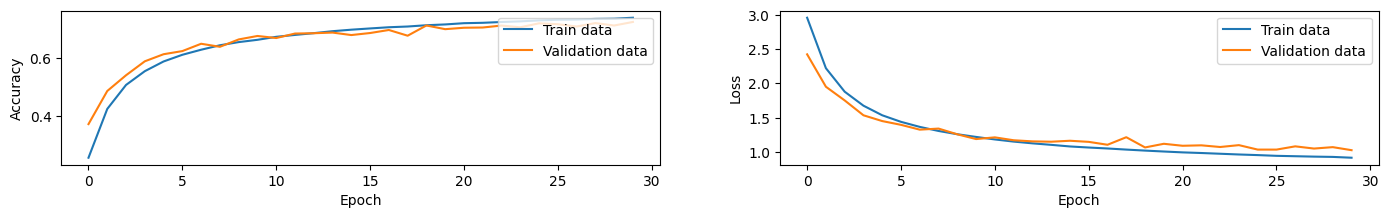

In [15]:
history = result

acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.figure(figsize=(17, 2))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_train, label='Train data')
plt.plot(range(epochs), acc_val, label='Validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss_train, label='Train data')
plt.plot(range(epochs), loss_val, label='Validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [16]:
scores = model.evaluate(val_ds, verbose=0)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

Val loss: 1.023097038269043
Val accuracy: 0.7229616641998291


In [17]:
predictions = model.predict(test_ds)
#print('Predictions:\n', predictions.numpy())

In [18]:
print('Predictions:\n', predictions[np.argmax(tf.nn.softmax(predictions[0]))])
test_scores = model.evaluate(test_ds, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Predictions:
 [5.74322003e-05 6.75322508e-06 7.68983318e-06 3.47144698e-04
 4.01541963e-02 1.72994807e-01 4.22971360e-02 2.35324592e-07
 3.08594696e-04 2.84368861e-02 2.99450835e-06 2.08428878e-06
 4.03358554e-03 2.40173307e-03 1.14639573e-01 5.71368655e-05
 1.48087651e-07 1.36093202e-03 7.89105240e-03 5.83256409e-03
 1.05733961e-04 1.78343053e-05 3.34906741e-04 6.59441212e-05
 8.28502234e-04 6.88258615e-06 1.43287017e-03 1.38441304e-04
 6.07494148e-05 4.64524096e-03 6.47221785e-03 1.27152067e-08
 6.25686371e-05 3.56766582e-01 6.22607840e-05 7.04110367e-04
 3.11676587e-04 9.45770589e-04 2.20870716e-03 1.45138238e-05
 8.53258360e-04 8.56434181e-03 1.86183900e-02 2.90275493e-05
 4.16061915e-02 1.45766899e-04 1.18609405e-05 9.50055197e-02
 2.00502709e-05 1.68001148e-04 4.43193421e-04 1.49245071e-03
 4.72677173e-04 4.43103211e-03 2.46433076e-02 5.42482958e-05
 3.22397827e-04 1.53358233e-05 1.12953114e-06 2.94431939e-05
 4.09662200e-04 5.70022501e-03 5.68329124e-04 4.32223253e-08
 3.7588449

# Saving the model
Firstly we save it in the default format and then the HDF5 format.

In [19]:
model_version = '0.1.4'

In [20]:
model.save('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.keras')

In [21]:
model.save('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.h5', save_format='h5')

In [22]:
model_json = model.to_json()
with open('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('./exported_models/v'+model_version+'/botaniai_model_weights_'+model_version+'.h5')
print("Saved model to disk")

Saved model to disk


# Convert model to tensorflow.js format

In [23]:
tfjs.converters.save_keras_model(model, './tensorflowjs/v'+model_version+'/')